# layers.Resizing() 분석

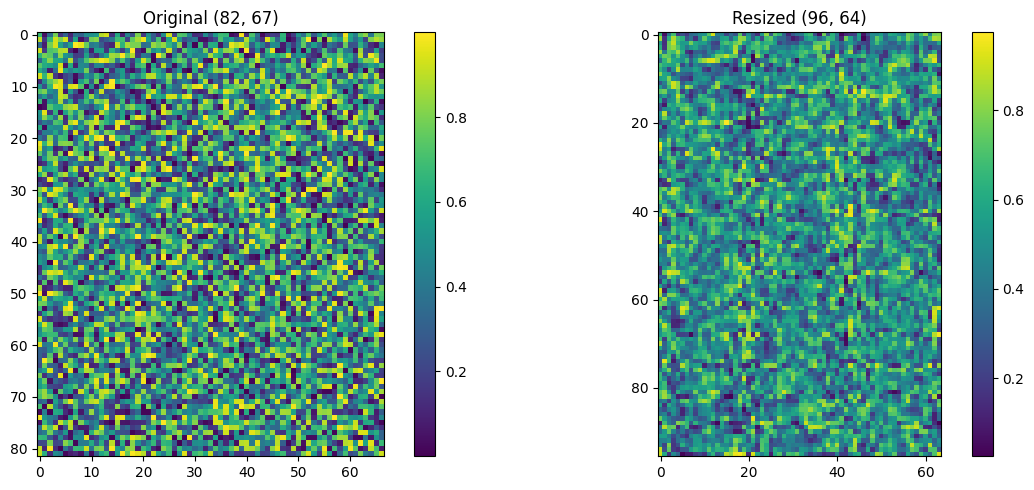

출력 픽셀 (0,0)의 입력 대응 좌표: x = -0.0729, y = 0.0234
출력 픽셀 (81,66)의 입력 대응 좌표: x = 81.9271, y = 67.0234


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def bilinear_resize(input_array, output_shape):
    """
    양선형 보간법을 이용하여 입력 배열을 지정한 출력 크기로 리사이징하는 함수.
    
    Args:
        input_array (ndarray): 입력 이미지 배열 (H_in, W_in)
        output_shape (tuple): 출력 크기 (H_out, W_out)
    
    Returns:
        ndarray: 리사이징된 배열 (H_out, W_out)
    """
    H_in, W_in = input_array.shape      # 입력 이미지 높이, 너비 (예: 82, 67)
    H_out, W_out = output_shape          # 출력 이미지 높이, 너비 (예: 96, 64)
    
    output = np.zeros((H_out, W_out), dtype=input_array.dtype)
    
    # 출력 좌표를 입력 좌표로 매핑하기 위한 스케일링 팩터 계산 (half-pixel centers 방식)
    scale_x = H_in / H_out   # 세로 방향 스케일링
    scale_y = W_in / W_out   # 가로 방향 스케일링
    
    # 각 출력 픽셀에 대해 대응하는 입력 좌표 계산 후 양선형 보간법 적용
    for i in range(H_out):
        for j in range(W_out):
            # 출력 픽셀 (i,j)의 중심 좌표에 해당하는 입력 좌표 (x, y)를 계산
            # 공식: x = (i + 0.5) * (H_in/H_out) - 0.5, y = (j + 0.5) * (W_in/W_out) - 0.5
            x = (i + 0.5) * scale_x - 0.5
            y = (j + 0.5) * scale_y - 0.5
            
            # x, y의 바닥값(floor)과 천장값(ceil) 계산 (경계값 처리를 위해 클리핑)
            x0 = int(np.floor(x))
            x1 = min(x0 + 1, H_in - 1)
            y0 = int(np.floor(y))
            y1 = min(y0 + 1, W_in - 1)
            
            # 만약 x0, y0가 음수가 되는 경우 0으로 조정
            x0 = max(x0, 0)
            y0 = max(y0, 0)
            
            # x와 y가 소수 부분: 보간 가중치 계산
            dx = x - x0  # 입력 좌표와 바닥 좌표 사이의 차이 (세로)
            dy = y - y0  # 입력 좌표와 바닥 좌표 사이의 차이 (가로)
            
            # 입력 이미지의 네 꼭짓점 값 추출
            Q11 = input_array[x0, y0]
            Q21 = input_array[x1, y0]
            Q12 = input_array[x0, y1]
            Q22 = input_array[x1, y1]
            
            # 양선형 보간법 공식:
            # f(x, y) = Q11*(1-dx)*(1-dy) + Q21*dx*(1-dy) + Q12*(1-dx)*dy + Q22*dx*dy
            value = (Q11 * (1 - dx) * (1 - dy) +
                     Q21 * dx * (1 - dy) +
                     Q12 * (1 - dx) * dy +
                     Q22 * dx * dy)
            
            output[i, j] = value
            
    return output

# 1. (82, 67) 크기의 임의의 데이터 생성 (예: 0~1 사이의 난수)
input_data = np.random.rand(82, 67)

# 2. 출력 크기를 (96, 64)로 지정
output_shape = (96, 64)

# 3. 직접 구현한 bilinear_resize 함수를 통해 리사이징 수행
resized_data = bilinear_resize(input_data, output_shape)

# 4. 리사이징 전과 후의 이미지를 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_data, cmap='viridis')
plt.title("Original (82, 67)")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(resized_data, cmap='viridis')
plt.title("Resized (96, 64)")
plt.colorbar()
plt.tight_layout()
plt.show()

# 5. 예시: 출력 이미지의 (0,0) 픽셀에 해당하는 입력 좌표 계산 (half-pixel centers 방식)
i, j = 0, 0
x = (i + 0.5) * (82 / 96) - 0.5
y = (j + 0.5) * (67 / 64) - 0.5
print("출력 픽셀 (0,0)의 입력 대응 좌표: x = {:.4f}, y = {:.4f}".format(x, y))

i, j = 96, 64
x = (i + 0.5) * (82 / 96) - 0.5
y = (j + 0.5) * (67 / 64) - 0.5
print("출력 픽셀 (81,66)의 입력 대응 좌표: x = {:.4f}, y = {:.4f}".format(x, y))


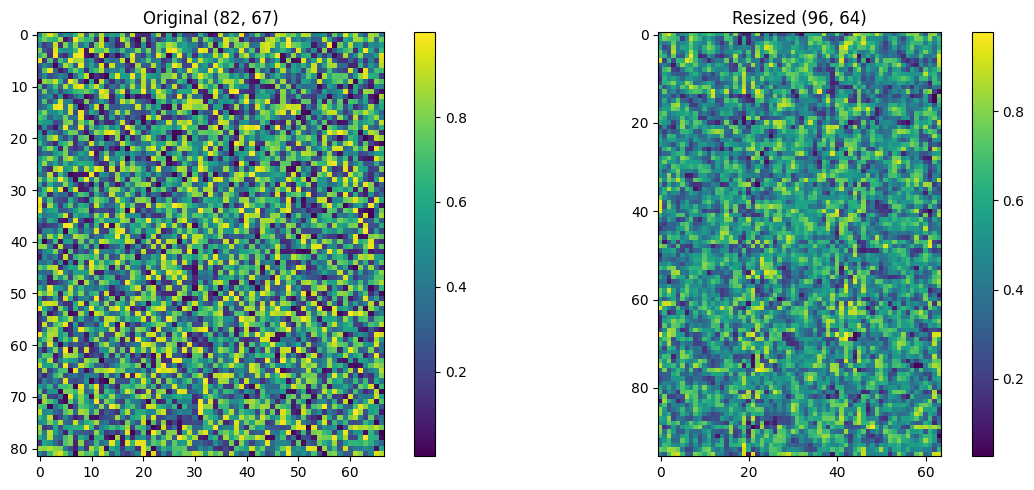

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. (82,67) 크기의 임의의 단일 채널 이미지 생성 (값은 0~1 사이의 난수)
original_image = np.random.rand(82, 67).astype(np.float32)
# 단일 채널 이미지로 만들어주기 위해 마지막 차원을 추가 (shape: (82,67,1))
original_image = original_image[..., np.newaxis]

hidden_size = [96, 64]

# 2. Resizing 레이어 인스턴스 생성 (출력 크기: 96 x 64, bilinear interpolation 사용)
resizing_layer = tf.keras.layers.Resizing(*hidden_size)
# 3. 단일 이미지는 배치 차원이 없으므로 배치 차원 추가 (shape: (1,82,67,1))
original_image_batch = np.expand_dims(original_image, axis=0)
# 4. Resizing 레이어를 적용하여 리사이즈 (결과 shape: (1,96,64,1))
resized_image_batch = resizing_layer(original_image_batch)
# 배치 차원 제거 (shape: (96,64,1))
resized_image = resized_image_batch[0].numpy()

# 5. 원본 이미지와 리사이즈된 이미지 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image[..., 0], cmap='viridis')
plt.title("Original (82, 67)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(resized_image[..., 0], cmap='viridis')
plt.title("Resized (96, 64)")
plt.colorbar()

plt.tight_layout()
plt.show()


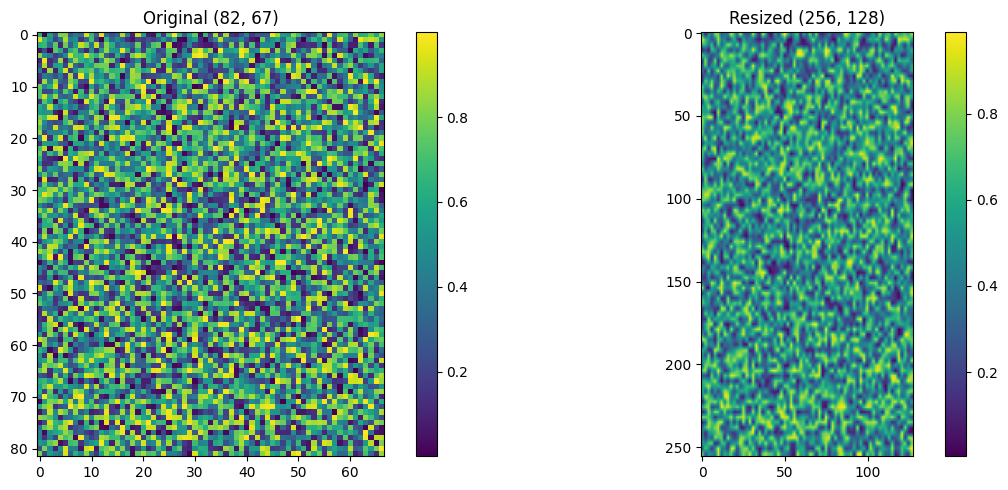

출력 픽셀 (0,0)의 입력 대응 좌표: x = -0.3398, y = -0.2383
출력 픽셀 (81,66)의 입력 대응 좌표: x = 81.6602, y = 66.7617


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def bilinear_resize(input_array, output_shape):
    """
    양선형 보간법을 이용하여 입력 배열을 지정한 출력 크기로 리사이징하는 함수.
    
    Args:
        input_array (ndarray): 입력 이미지 배열 (H_in, W_in)
        output_shape (tuple): 출력 크기 (H_out, W_out)
    
    Returns:
        ndarray: 리사이징된 배열 (H_out, W_out)
    """
    H_in, W_in = input_array.shape      # 입력 이미지 높이, 너비 (예: 82, 67)
    H_out, W_out = output_shape          # 출력 이미지 높이, 너비 (예: 96, 64)
    
    output = np.zeros((H_out, W_out), dtype=input_array.dtype)
    
    # 출력 좌표를 입력 좌표로 매핑하기 위한 스케일링 팩터 계산 (half-pixel centers 방식)
    scale_x = H_in / H_out   # 세로 방향 스케일링
    scale_y = W_in / W_out   # 가로 방향 스케일링
    
    # 각 출력 픽셀에 대해 대응하는 입력 좌표 계산 후 양선형 보간법 적용
    for i in range(H_out):
        for j in range(W_out):
            # 출력 픽셀 (i,j)의 중심 좌표에 해당하는 입력 좌표 (x, y)를 계산
            # 공식: x = (i + 0.5) * (H_in/H_out) - 0.5, y = (j + 0.5) * (W_in/W_out) - 0.5
            x = (i + 0.5) * scale_x - 0.5
            y = (j + 0.5) * scale_y - 0.5
            
            # x, y의 바닥값(floor)과 천장값(ceil) 계산 (경계값 처리를 위해 클리핑)
            x0 = int(np.floor(x))
            x1 = min(x0 + 1, H_in - 1)
            y0 = int(np.floor(y))
            y1 = min(y0 + 1, W_in - 1)
            
            # 만약 x0, y0가 음수가 되는 경우 0으로 조정
            x0 = max(x0, 0)
            y0 = max(y0, 0)
            
            # x와 y가 소수 부분: 보간 가중치 계산
            dx = x - x0  # 입력 좌표와 바닥 좌표 사이의 차이 (세로)
            dy = y - y0  # 입력 좌표와 바닥 좌표 사이의 차이 (가로)
            
            # 입력 이미지의 네 꼭짓점 값 추출
            Q11 = input_array[x0, y0]
            Q21 = input_array[x1, y0]
            Q12 = input_array[x0, y1]
            Q22 = input_array[x1, y1]
            
            # 양선형 보간법 공식:
            # f(x, y) = Q11*(1-dx)*(1-dy) + Q21*dx*(1-dy) + Q12*(1-dx)*dy + Q22*dx*dy
            value = (Q11 * (1 - dx) * (1 - dy) +
                     Q21 * dx * (1 - dy) +
                     Q12 * (1 - dx) * dy +
                     Q22 * dx * dy)
            
            output[i, j] = value
            
    return output

# 1. (82, 67) 크기의 임의의 데이터 생성 (예: 0~1 사이의 난수)
input_data = np.random.rand(82, 67)

output_shape = (256, 128)

# 3. 직접 구현한 bilinear_resize 함수를 통해 리사이징 수행
resized_data = bilinear_resize(input_data, output_shape)

# 4. 리사이징 전과 후의 이미지를 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_data, cmap='viridis')
plt.title("Original (82, 67)")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(resized_data, cmap='viridis')
plt.title("Resized (256, 128)")
plt.colorbar()
plt.tight_layout()
plt.show()

# 5. 예시: 출력 이미지의 (0,0) 픽셀에 해당하는 입력 좌표 계산 (half-pixel centers 방식)
i, j = 0, 0
x = (i + 0.5) * (82 / 256) - 0.5
y = (j + 0.5) * (67 / 128) - 0.5
print("출력 픽셀 (0,0)의 입력 대응 좌표: x = {:.4f}, y = {:.4f}".format(x, y))

i, j = 256, 128
x = (i + 0.5) * (82 / 256) - 0.5
y = (j + 0.5) * (67 / 128) - 0.5
print("출력 픽셀 (81,66)의 입력 대응 좌표: x = {:.4f}, y = {:.4f}".format(x, y))


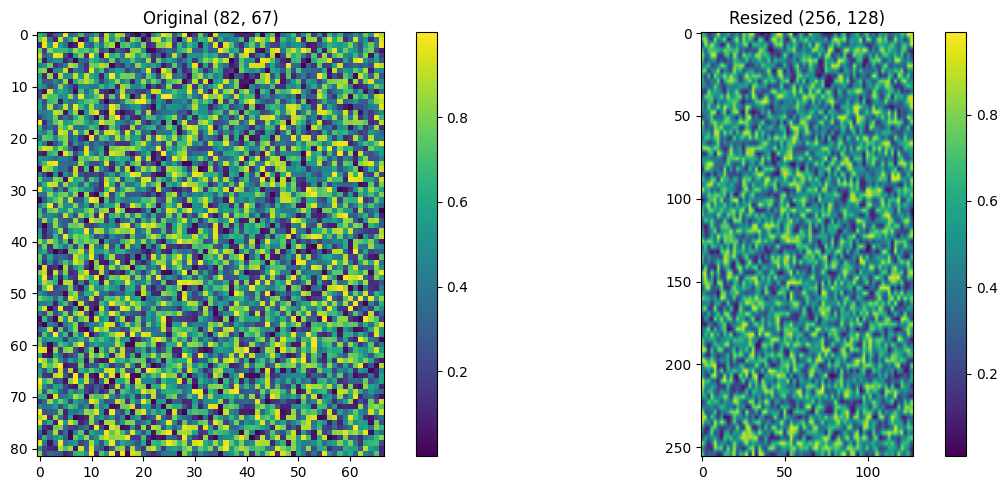

In [23]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. (82,67) 크기의 임의의 단일 채널 이미지 생성 (값은 0~1 사이의 난수)
original_image = np.random.rand(82, 67).astype(np.float32)
# 단일 채널 이미지로 만들어주기 위해 마지막 차원을 추가 (shape: (82,67,1))
original_image = original_image[..., np.newaxis]

hidden_size = [256, 128]

resizing_layer = tf.keras.layers.Resizing(*hidden_size)
original_image_batch = np.expand_dims(original_image, axis=0)
resized_image_batch = resizing_layer(original_image_batch)
resized_image = resized_image_batch[0].numpy()

# 5. 원본 이미지와 리사이즈된 이미지 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image[..., 0], cmap='viridis')
plt.title("Original (82, 67)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(resized_image[..., 0], cmap='viridis')
plt.title("Resized (256, 128)")
plt.colorbar()

plt.tight_layout()
plt.show()


# 입력 데이터 및 리사이징 데이터 시각화

In [24]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.model.layers import GriddingLayer

In [25]:
# 입력 데이터셋 로드
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_interaction_v3.csv', index_col=0)
ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data = ctrl_data[:, :17*4]

# 레이블 데이터 로드
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'
label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))
label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

test_split = 0.4  # 테스트 샘플 비율 (1=100%)
random_seed = 42  # 랜덤 샘플링 시 고정 시드값

X_emis_train, X_emis_test, y_train, y_test = train_test_split(emis_data, label_data, test_size=test_split, random_state=random_seed)

input_data = X_emis_train[0]

Input data shape: (68,)
1/1 [==============================] - 0s 336ms/step


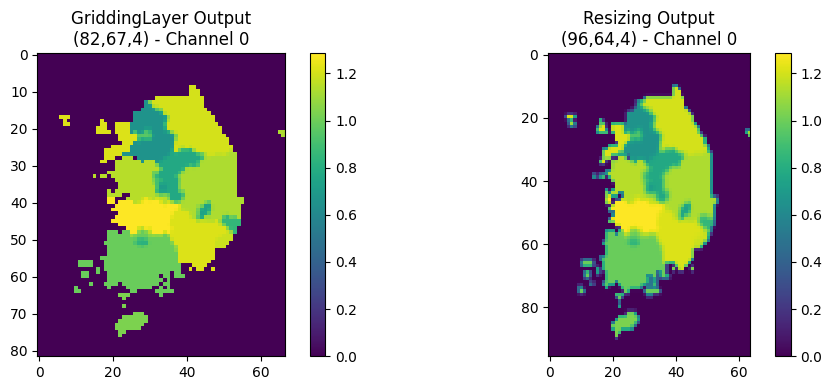

In [26]:
# (예시를 위해) ctrl_dim과 hidden_size 설정
ctrl_dim = 17 * 4   # 즉 68
hidden_size = [96, 64]  # 목표 높이와 너비

# 1. 임의의 입력 데이터 생성 (68,) - 실제 모델에서는 X_emis_train[0]이 될 것
input_data = X_emis_train[0]
print("Input data shape:", input_data.shape)  # (68,)

# 2. 모델의 초기 처리 과정을 모사하는 서브 모델 정의
#    GriddingLayer를 적용해서 (82,67,4) 크기의 텐서를 생성하는 모델
input_tensor = tf.keras.Input(shape=(ctrl_dim,))
# 여기서 ctrl_dim//17는 채널 수 (4)를 의미함
ctrl_maps = GriddingLayer()(input_tensor, ctrl_dim // 17)
# ctrl_maps의 shape: (batch_size, 82, 67, 4)

model_gridding = tf.keras.Model(inputs=input_tensor, outputs=ctrl_maps)

# 3. Resizing 레이어를 적용하여 (82,67,4) -> (96,64,4)로 재조정하는 서브 모델
resized_ctrl_maps = tf.keras.layers.Resizing(*hidden_size)(ctrl_maps)
model_resizing = tf.keras.Model(inputs=input_tensor, outputs=resized_ctrl_maps)

# 4. 입력 데이터를 배치 차원 추가 후 모델 실행
input_data_batch = np.expand_dims(input_data, axis=0)  # shape: (1, 68)
ctrl_maps_val = model_gridding.predict(input_data_batch)  # (1, 82, 67, 4)
resized_val = model_resizing.predict(input_data_batch)    # (1, 96, 64, 4)

# 5. 결과 시각화 (여기서는 채널 0만 선택)
ctrl_maps_img = ctrl_maps_val[0, :, :, 0]   # (82,67)
resized_img = resized_val[0, :, :, 0]         # (96,64)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud(ctrl_maps_img), cmap='viridis')
plt.title("GriddingLayer Output\n(82,67,4) - Channel 0")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(resized_img), cmap='viridis')
plt.title("Resizing Output\n(96,64,4) - Channel 0")
plt.colorbar()

plt.tight_layout()
plt.show()
